In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train, device=device, dtype=torch.float32),
    torch.tensor(X_test, device=device, dtype=torch.float32),
    torch.tensor(y_train, device=device, dtype=torch.long),
    torch.tensor(y_test, device=device, dtype=torch.long),
)

In [2]:
import torch.nn as nn
class IrisClassifier(nn.Module):
    def __init__(self):
        super(IrisClassifier, self).__init__()
        self.linear = nn.Linear(
            4, 3
        )  # input size is 4 (number of features), output size is 3 (number of classes)

    def forward(self, x):
        x = self.linear(x)
        return x

In [3]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
from collections import namedtuple
from torch.utils.data import DataLoader

ModelInfo = namedtuple("ModelInfo", ["state_dict", "matrix", "accuracy"])

def train_model(train_loader: DataLoader):
    model = IrisClassifier().to(device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    model.train()
    num_epochs = 200
    for _ in range(num_epochs):
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, labels = torch.max(y_pred, 1)
        accuracy = accuracy_score(y_test.numpy(), labels.numpy())
    W = model.linear.weight.data
    b = model.linear.bias.data
    b = b.view(-1, 1)
    Wb_matrix = torch.cat((W, b), dim=1)
    return ModelInfo(state_dict=model.state_dict(), matrix=Wb_matrix, accuracy=accuracy)

In [4]:
from torch.utils.data import TensorDataset, DataLoader

NUM_OF_MODELS = 25

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

real_models = []
for _ in range(NUM_OF_MODELS):
    model_info = train_model(train_loader)
    #print(model_info.accuracy)
    real_models.append(model_info)

In [5]:
scrambled_models = []
for _ in range(NUM_OF_MODELS):
    scramble_indices = torch.randperm(y_train.size(0), device=device)
    y_train_scrambled = y_train[scramble_indices]

    train_dataset_scrambled = TensorDataset(X_train, y_train_scrambled)
    train_loader_scrambled = DataLoader(
        train_dataset_scrambled, batch_size=16, shuffle=True
    )
    model_info = train_model(train_loader_scrambled)
    #print(model_info.accuracy)
    scrambled_models.append(model_info)

In [6]:
from torch import linalg as LA
import torch.nn.functional as F

def metric(A, B):
    return LA.matrix_norm((A - B), ord=2).item()

distances_real_real = []
distances_scrambled_scrambled = []
for i in range(NUM_OF_MODELS):
    for j in range(i + 1, NUM_OF_MODELS):
        d_r_r = metric(real_models[i].matrix, real_models[j].matrix)
        d_s_s = metric(scrambled_models[i].matrix, scrambled_models[j].matrix)
        distances_real_real.append(d_r_r)
        distances_scrambled_scrambled.append(d_s_s)

distances_real_scrambled = []
for r in real_models:
    for s in scrambled_models:
        d_r_s = metric(r.matrix, s.matrix)
        distances_real_scrambled.append(d_r_s)

In [7]:
import pandas as pd
import numpy as np

def reshape_to_matrix(distances_list):
    matrix = np.zeros((NUM_OF_MODELS, NUM_OF_MODELS))
    index = 0
    for i in range(NUM_OF_MODELS):
        for j in range(i + 1, NUM_OF_MODELS):
            matrix[i][j] = distances_list[index]
            matrix[j][i] = distances_list[index]
            index += 1
    return matrix

real_real_matrix = reshape_to_matrix(distances_real_real)
real_scrambled_matrix = np.reshape(
    distances_real_scrambled, (NUM_OF_MODELS, NUM_OF_MODELS)
)
scrambled_scrambled_matrix = reshape_to_matrix(distances_scrambled_scrambled)

df_real_real = pd.DataFrame(real_real_matrix)
df_real_scrambled = pd.DataFrame(real_scrambled_matrix)
df_scrambled_scrambled = pd.DataFrame(scrambled_scrambled_matrix)

df_real_real.to_csv(
    f"distances_matrix/{NUM_OF_MODELS}_models/D(R,R).csv", index=False, header=False, float_format="%.3f"
)
df_real_scrambled.to_csv(
    f"distances_matrix/{NUM_OF_MODELS}_models/D(R,S).csv", index=False, header=False, float_format="%.3f"
)
df_scrambled_scrambled.to_csv(
    f"distances_matrix/{NUM_OF_MODELS}_models/D(S,S).csv", index=False, header=False, float_format="%.3f"
)

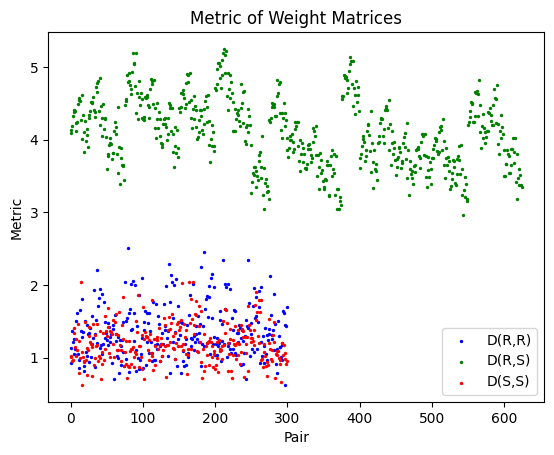

In [65]:
import matplotlib.pyplot as plt

plt.scatter(
    range(len(distances_real_real)),
    distances_real_real,
    color="blue",
    label="D(R,R)",
    s=2,
)
plt.scatter(
    range(len(distances_real_scrambled)),
    distances_real_scrambled,
    color="green",
    label="D(R,S)",
    s=2,
)
plt.scatter(
    range(len(distances_scrambled_scrambled)),
    distances_scrambled_scrambled,
    color="red",
    label="D(S,S)",
    s=2,
)
plt.xlabel("Pair")
plt.ylabel("Metric")
plt.legend()
plt.title("Metric of Weight Matrices")
plt.show()

In [66]:
from sklearn.manifold import TSNE

upper_left_block = real_real_matrix
upper_right_block = real_scrambled_matrix
lower_left_block = real_scrambled_matrix.T
lower_right_block = scrambled_scrambled_matrix

distances_matrix = np.block(
    [[upper_left_block, upper_right_block], [lower_left_block, lower_right_block]]
)

perplexity = min(15, 2 * NUM_OF_MODELS - 1)
tsne = TSNE(n_components=2, perplexity=perplexity)
embedded_distances_matrix = tsne.fit_transform(distances_matrix)
embedded_real = embedded_distances_matrix[:NUM_OF_MODELS]
embedded_scrambled = embedded_distances_matrix[NUM_OF_MODELS:]

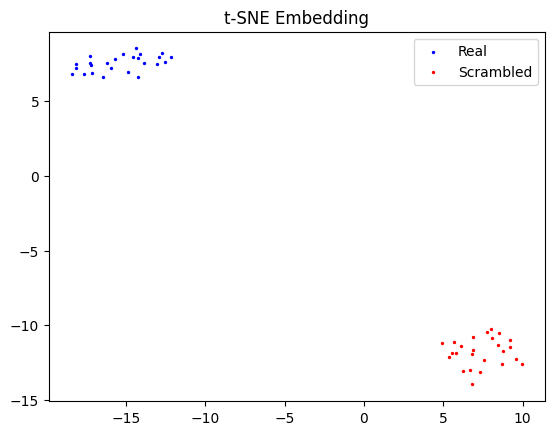

In [67]:
plt.scatter(embedded_real[:, 0], embedded_real[:, 1], color="blue", label="Real", s=2)
plt.scatter(
    embedded_scrambled[:, 0],
    embedded_scrambled[:, 1],
    color="red",
    label="Scrambled",
    s=2,
)
plt.title("t-SNE Embedding")
plt.legend()
plt.title("t-SNE Embedding")
plt.show()

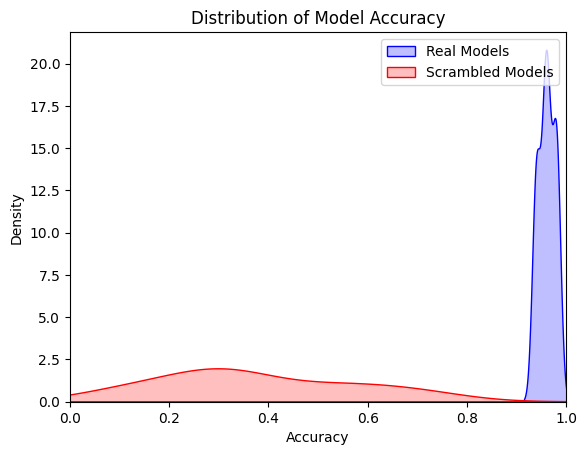

In [68]:
import seaborn as sns

real_accuracies = [model.accuracy for model in real_models]
scrambled_accuracies = [model.accuracy for model in scrambled_models]

sns.kdeplot(real_accuracies, color="blue", label="Real Models", fill=True)
sns.kdeplot(scrambled_accuracies, color="red", label="Scrambled Models", fill=True)

plt.xlabel("Accuracy")
plt.ylabel("Density")
plt.title("Distribution of Model Accuracy")
plt.xlim(0, 1)
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import confusion_matrix

diagonal_real = []
diagonal_scrambled = []

for model_info in real_models:
    model = IrisClassifier().to(device=device)
    model.load_state_dict(model_info.state_dict)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, predicted_labels = torch.max(y_pred, 1)
    cm = confusion_matrix(y_test.cpu().numpy(), predicted_labels.cpu().numpy())
    diagonal = np.sum(np.diag(cm))
    diagonal_real.append(diagonal / len(y_test))

for model_info in scrambled_models:
    model = IrisClassifier().to(device=device)
    model.load_state_dict(model_info.state_dict)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, predicted_labels = torch.max(y_pred, 1)
    cm = confusion_matrix(y_test.cpu().numpy(), predicted_labels.cpu().numpy())
    diagonal = np.sum(np.diag(cm))
    diagonal_scrambled.append(diagonal / len(y_test))

print("Diag(R): {:.4f}".format(np.mean(diagonal_real)))
print("Diag(S): {:.4f}".format(np.mean(diagonal_scrambled)))

Diag(R): 0.9608
Diag(S): 0.3744
